Exercise 4.7
Problem type: original_problem
Iteration 1
Delta 193.34904927509484
Delta 134.00426086446845
Delta 90.45243773746199
Delta 67.59779106615343
Delta 53.58493061758014
Delta 41.72086291128443
Delta 32.72010939685646
Delta 26.08755613817374
Delta 21.778143392698667
Delta 18.318059790333052
Delta 15.36740634770041
Delta 12.86102712361577
Delta 10.739286690814538
Delta 8.94900414527234
Delta 7.443128433755987
Delta 6.180206266077221
Delta 5.123897292162155
Delta 4.242540347244358
Delta 3.5087368683553564
Delta 2.898934555426024
Delta 2.393012044082411
Delta 1.973873579669771
Delta 1.627063832004012
Delta 1.340410800752295
Delta 1.1037016637393435
Delta 0.9083935811092942
Delta 0.7473592909598779
Delta 0.6146658513114289
Delta 0.5053839897116177
Delta 0.41542507105862114
Delta 0.3414025532431424
Delta 0.28051486211569454
Delta 0.23044680201371648
Delta 0.18928686930127014
Delta 0.15545811562668632
Delta 0.12766049026510018
Delta 0.10482286156798182
Delta 0.08606316780401357
Delta

TypeError: FigureBase.gca() got an unexpected keyword argument 'projection'

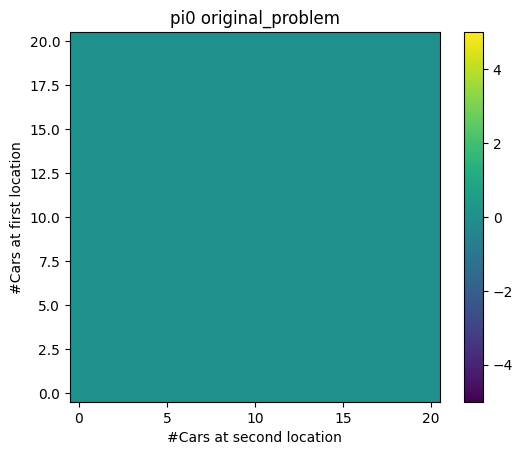

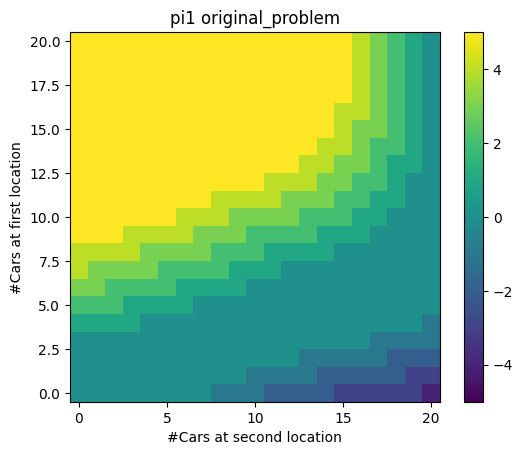

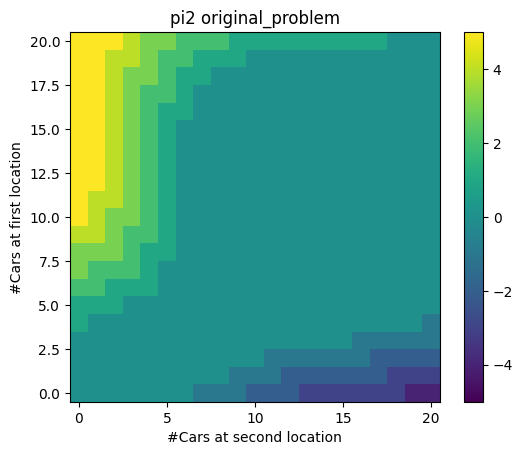

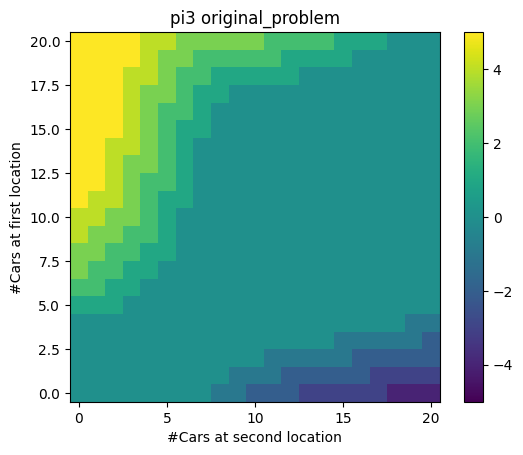

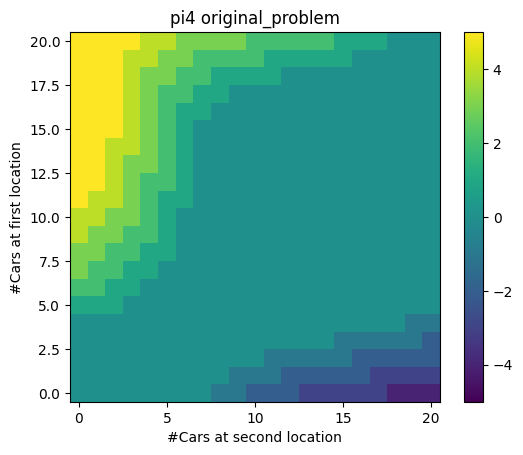

<Figure size 640x480 with 0 Axes>

In [1]:
# JACK'S CAR RENTAL
#
# EXERCISE 4.7
#
# Write a program for policy iteration and re-solve Jack's car rental problem with the following changes. One of Jack's
# employees at the first location rides a bus home each night and lives near the second location. She is happy to
# shuttle one car to the second location for free. Each additional car still costs $2, as do all cars moved in the other
# direction. In addition, Jack has limited parking space at each location. If more than 10 cars are kept overnight at a
# location (after any moving of cars), then an additional cost of $4 must be incurred to use a second parking lot
# (independent of how many cars are kept there). These sorts of nonlinearities and arbitrary dynamics often occur in
# real problems and cannot easily be handled by optimization methods other than dynamic programming. To check your
# program, first replicate the results given for the original problem. If your computer is too slow for the full
# problem, cut all the numbers of cars in half.

import numpy as np
import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# A wrapper class for parameters of the algorithm
class Params:
    def __init__(self):
        # Max number of cars for each location
        self.max_car = 20

        # Max number of cars to move each night
        self.max_move = 5

        # Reward given to rent a car
        self.reward_per_car = 10

        # Cost to keep more car than half the maximum overnight, for the modified version of Jack's Car Rental problem
        self.cost_per_slot_night = 4

        # Cost to move a car
        self.cost_per_car = 2

        # Small number determining the accuracy of policy evaluation's estimation
        self.theta = 0.01

        # Discount value
        self.gamma = 0.9

        # Expectation for rental requests in first location
        self.lambda_request_first = 3

        # Expectation for rental requests in second location
        self.lambda_request_second = 4

        # Expectation for returns in first location
        self.lambda_return_first = 3

        # Expectation for returns in second location
        self.lambda_return_second = 2

        # Possible versions of the problem
        self.problem_types = ['original_problem', 'modified_problem']


# A wrapper class for Policy Iteration algorithm
class PolicyIteration:
    def __init__(self, params, problem_type):
        # Set up parameters
        self.params = params

        # Set up the problem type
        self.problem_type = problem_type

        # All possible states
        self.S = [(x, y) for x in range(self.params.max_car + 1) for y in range(self.params.max_car + 1)]

        # Value function
        self.V = np.zeros((self.params.max_car + 1, self.params.max_car + 1))

        # Policy function
        self.pi = np.zeros((self.params.max_car + 1, self.params.max_car + 1))

        # List of policy functions
        self.pis = []

    def solve_problem(self):
        """
        Resolve Jack's Car Rental problem using Policy Iteration
        """
        i = 0
        while True:
            print('Iteration', i + 1)

            # Policy evaluation
            self.pis.append(self.pi.copy())
            while True:
                delta = 0
                for s in self.S:
                    v = self.V[s]
                    self.V[s] = self.V_eval(s, self.pi[s])
                    delta = np.maximum(delta, abs(v - self.V[s]))
                if delta < self.params.theta:
                    break
                print('Delta', delta)

            # Policy improvement
            policy_stable = True
            for s in self.S:
                old_action = self.pi[s]
                values = {a: self.V_eval(s, a) for a in self.A(s)}
                self.pi[s] = np.random.choice([a for a, value in values.items()
                                               if value == np.max(list(values.values()))])
                if old_action != self.pi[s]:
                    policy_stable = False

            if policy_stable:
                break

            i += 1

    def A(self, s):
        """
        Get all possible actions given a state
        :param s: state
        :return: possible actions
        """
        values = []

        # All possible actions
        A = [x for x in range(-self.params.max_move, self.params.max_move + 1)]
        s_first, s_second = s

        # Discard actions that would make the number of car negative or higher than max in at least one of the locations
        for a in A:
            if s_first - a < 0 or s_first - a > self.params.max_car:
                continue
            if s_second + a < 0 or s_second + a > self.params.max_car:
                continue
            values.append(a)
        return values

    def V_eval(self, s, a):
        """
        Compute value given a state and an action for the state following the formula:
        sum over all s',r of p(s',r|s, a)[r + gamma*V(s')]
        :param s: state
        :param a: action
        :return: value
        """
        value = 0
        s_first, s_second = s

        # Take the action
        s_first -= int(a)
        s_second += int(a)

        # Compute the cost of the action
        if self.problem_type == 'original_problem':
            cost = self.params.cost_per_car * abs(a)
        else:
            if a > 0:
                a -= 1
            cost = self.params.cost_per_car * abs(a) + self.params.cost_per_slot_night * (
                1 if s_first > self.params.max_car / 2 else 0 + 1 if s_second > self.params.max_car / 2 else 0)

        # Compute for each possible new state: probability, reward, and value of the new state, then apply the formula
        sum_prob_i = 0
        for i in range(s_first + 1):
            if i == s_first:
                p_i = 1 - sum_prob_i
            else:
                p_i = PolicyIteration.poisson(self.params.lambda_request_first, i)
                sum_prob_i += p_i
            r_i = i * self.params.reward_per_car
            sum_prob_j = 0
            for j in range(s_second + 1):
                if j == s_second:
                    p_j = 1 - sum_prob_j
                else:
                    p_j = PolicyIteration.poisson(self.params.lambda_request_second, j)
                    sum_prob_j += p_j
                r_j = j * self.params.reward_per_car
                sum_prob_k = 0
                for k in range(self.params.max_car + i - s_first + 1):
                    if k == self.params.max_car + i - s_first:
                        p_k = 1 - sum_prob_k
                    else:
                        p_k = PolicyIteration.poisson(self.params.lambda_return_first, k)
                        sum_prob_k += p_k
                    sum_prob_l = 0
                    for l in range(self.params.max_car + j - s_second + 1):
                        if l == self.params.max_car + j - s_second:
                            p_l = 1 - sum_prob_l
                        else:
                            p_l = PolicyIteration.poisson(self.params.lambda_return_second, l)
                            sum_prob_l += p_l

                        value += p_i * p_j * p_k * p_l * (
                                 r_i + r_j - cost + self.params.gamma * self.V[s_first - i + k, s_second - j + l])
        return value

    def print_pis(self):
        """
        Print policies
        """
        for idx, pi in enumerate(self.pis):
            plt.figure()
            plt.imshow(pi, origin='lower', interpolation='none', vmin=-self.params.max_move, vmax=self.params.max_move)
            plt.xlabel('#Cars at second location')
            plt.ylabel('#Cars at first location')
            plt.title('pi{:d} {:s}'.format(idx, self.problem_type))
            plt.colorbar()

    def print_V(self):
        """
        Print values
        """
        fig = plt.figure()
        ax = fig.gca(projection='3d')
        X = np.arange(0, self.params.max_car + 1)
        Y = np.arange(0, self.params.max_car + 1)
        X, Y = np.meshgrid(X, Y)
        ax.plot_surface(X, Y, self.V)
        plt.title('V {:s}'.format(self.problem_type))

    @staticmethod
    def poisson(lamb, n):
        """
        :param lamb: lambda parameter of poisson distribution, rate
        :param n: n variable of poisson distribution, number of occurrences
        :return: probability of the event
        """
        return (lamb ** n) * math.exp(-lamb) / math.factorial(n)


def exercise4_7():
    print('Exercise 4.7')

    # Set up parameters
    params = Params()

    for problem_type in params.problem_types:
        print('Problem type:', problem_type)

        # Set up the algorithm
        policy_iteration = PolicyIteration(params, problem_type)

        # Solve the problem
        policy_iteration.solve_problem()

        # Show results
        policy_iteration.print_pis()
        policy_iteration.print_V()

exercise4_7()
plt.show()